# STS reader example script 

## Example script to run STM reader

### Run multiple files with a single script
The script can run multiple `sts` or `stm` files from a directory or nested directory. 

In [1]:
import os
import subprocess

    
def get_list_of_files(dir_, ext):
    """
    Get the list of files with the given extension.
    """
    import os
    files_out = []

    if not os.path.exists(dir_):
        raise ValueError("Directory does not exist")#

    for root, dirs, files in os.walk(dir_):

        for file in files:
            if file.endswith(ext):
                file = os.path.join(root, file)
                files_out.append(os.path.abspath(file))
        for dir_nested in dirs:
            files_out.extend(get_list_of_files(os.path.join(root, dir_nested), ext))
    return files_out


def run_dataconverter_recursive(eln, config, 
                                file_ext=None, input_file=None, 
                                dir_=None, max_file=3):
    eln = os.path.abspath(eln)
    config = os.path.abspath(config)
    if not os.path.isfile(eln):
        raise ValueError(f"Eln is not a vilid file or not have correct path {eln}")
    if not os.path.isfile(config):
        raise ValueError(f"Config is not a vilid file or not have correct path {config}")
    input_files = []
    if input_file or dir_:
        if input_file:
            input_files.append(input_file)
        else:
            dir_ = os.path.abspath(dir_)
            input_files = get_list_of_files(dir_, ext=file_ext)
    i = 0
    for file in input_files:
        if i>= max_file:
            return
        i = i + 1
        command = [
                    "dataconverter",
                    "--input-file", file,
                    "--input-file", eln,
                    "--input-file", config,
                    "--reader", "sts",
                    "--nxdl", "NXsts",
                    "--output", f"{file.replace(file_ext, 'nxs')}"
                  ]

        result = subprocess.run(command, shell=False, 
                                capture_output=True, text=True)
        if result.returncode == 0:
            print("Command executed successfully ...")
            print("Output : ... \n", result.stdout)
        else:
            print("Command failed with return code ...", result.returncode)
            print("Error :  ... \n", result.stderr)

### Reads plot data from NXdata
The below script reads the numpy array from NXdata from a or a list `.nxs` file.


In [2]:
import numpy as np
import h5py as h5
from pathlib import Path
import copy
plot = {"f_value": None,
        "f_name": None,
        "f_unit": None,
        "a_values": [],
        "a_units": [],
        "a_names": [],
        "file_name": None,
        "plot_name": None}


def get_plot_data(node, file_name="test_file", 
                  grp_name="grp_name", empty_plot=plot,
                  ):
    """
    Collect data for plots from NXdata group.
    """
    plot = copy.deepcopy(empty_plot)
    plot["file_name"] = file_name
    plot_annotation = file_name
    # Add the functionality to see the default plot.
    attrs = node.attrs
    axes = attrs.get("axes", [])
    if not len(axes):
        return {}
    field_key = ""
    for key, val in node.items():
        # field
        i = 1
        if key not in axes:
            if isinstance(val, h5.Dataset):
                field_key = key
                plot_annotation = plot_annotation + "_fld( " + key + " )"
                plot["plot_name"] = plot_annotation
                plot["f_value"] = np.array(val)
                plot["f_name"] = key
                # field metadata
                for attr_k, attr_v in val.attrs.items():
                    if "units" == attr_k:
                        plot["f_unit"] = attr_v
        # attribute
        elif key in axes:
            plot["a_names"].append(key)
            plot["a_values"].append(np.array(val))
            i = i + 1
            for attr_k, attr_v in val.attrs.items():
                if attr_k == "units":
                    plot["a_units"].append(attr_v)
                
    return plot
    

def walk_through_NXdata(h5_node, plot_li, file_name, node_name=""):
    """Walk through each node.
    """
    for key, val in h5_node.items():
        if isinstance(val, h5.Group):
            if val.attrs.get("NX_class", None) == "NXdata":
                if not node_name:
                    plot_li.append(get_plot_data(val, file_name=file_name, grp_name=key))
                elif key==node_name:
                    plot_li.append(get_plot_data(val, file_name=file_name, grp_name=key))
                    
            else:
                walk_through_NXdata(val, plot_li, file_name=file_name, node_name=node_name)
    

def read_and_store_plot_data(hdf5_file, plot_li, node_name=""):
    """
    Extract and store plot data in the hdf5 file.
    hdf5_file:
        A hdf5_file or a list of hdf5_file
    node_name:
        If any specific NXdata node is being chosen then the function will collect all the 
        nodes from all the `nxs` file otherwise all kind of NXdata node will be collected and store.
    """
    
    if isinstance(hdf5_file, (list, tuple)):
        for file in hdf5_file:
            read_and_store_plot_data(file, plot_li, 
                                     node_name=node_name)
        return

    try:
        stem = Path(hdf5_file).stem
        h5_file = h5.File(hdf5_file, "r+")
        walk_through_NXdata(h5_file, plot_li, 
                            file_name=stem, node_name=node_name)
        h5_file.close()
    except ValueError:
        raise (f'Either file "{hdf5_file}"does not exist or it is corupted.')
    return

### Plots script
The `plots` function can plot multiple plots from list of `plot` object.

```python
# Plot Object
plot = {"f_value": None,
        "f_name": None,
        "f_unit": None,
        "a_values": [],
        "a_units": [],
        "a_names": [],
        "file_name": None,
        "plot_name": None}
```

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plots(plt_dt_li, ncol=3, figsize = (8,6)):
    tot_plt = len(plot_li)
    if tot_plt < ncol:
        ncol = tot_plt
    nrow = int(np.ceil(tot_plt / ncol))
    fig, axes = plt.subplots(nrows=nrow,
                             ncols=ncol,
                             figsize=figsize
                            )
    for ind, plot_dct in enumerate(plt_dt_li):
        row_ind = int(ind/ncol)
        col_ind = int(ind % ncol)
        naxis = row_ind * ncol + ncol
        if ncol < tot_plt:
            naxis = (row_ind, col_ind)
        else:
            naxis = (ind)
            
        if tot_plt > 1:
            axes[naxis].plot(plot_dct["a_values"][0], 
                             plot_dct["f_value"])
            axes[naxis].set_title(plot_dct["plot_name"])
        else:
            axes.plot(plot_dct["a_values"][0], 
                             plot_dct["f_value"])
            axes.set_title(plot_dct["plot_name"])
            
    plt.tight_layout()
    plt.show()

## Convert all the `sts` or `stm` file from a directory or nested directory

In [4]:

# Run sts reader
config = '../sts_example/config_file_for_dat.json'
eln = '../sts_example/eln_data.yaml'

run_dataconverter_recursive(eln=eln, config=config, 
                            file_ext='dat', input_file=None, 
                            dir_='../', max_file=3)

Command executed successfully ...
Output : ... 
  #####  () ('/home/rubel/NOMAD-FAIRmat/GL/sts/example/STS_nanonis_generic_5e_1.dat', '/home/rubel/NOMAD-FAIRmat/GL/sts/example/sts_example/eln_data.yaml', '/home/rubel/NOMAD-FAIRmat/GL/sts/example/sts_example/config_file_for_dat.json') sts NXsts /home/rubel/NOMAD-FAIRmat/GL/sts/example/STS_nanonis_generic_5e_1.nxs False False False False None

Command executed successfully ...
Output : ... 
  #####  () ('/home/rubel/NOMAD-FAIRmat/GL/sts/example/STS_nanonis_generic_4_5.dat', '/home/rubel/NOMAD-FAIRmat/GL/sts/example/sts_example/eln_data.yaml', '/home/rubel/NOMAD-FAIRmat/GL/sts/example/sts_example/config_file_for_dat.json') sts NXsts /home/rubel/NOMAD-FAIRmat/GL/sts/example/STS_nanonis_generic_4_5.nxs False False False False None

Command executed successfully ...
Output : ... 
  #####  () ('/home/rubel/NOMAD-FAIRmat/GL/sts/example/STS_nanonis_generic_5e_2.dat', '/home/rubel/NOMAD-FAIRmat/GL/sts/example/sts_example/eln_data.yaml', '/home/r

## PLot from all the nexus file form `dir`

For large number of plots change the figure size
```python
plots(plot_li, figsize=(10,10))
```

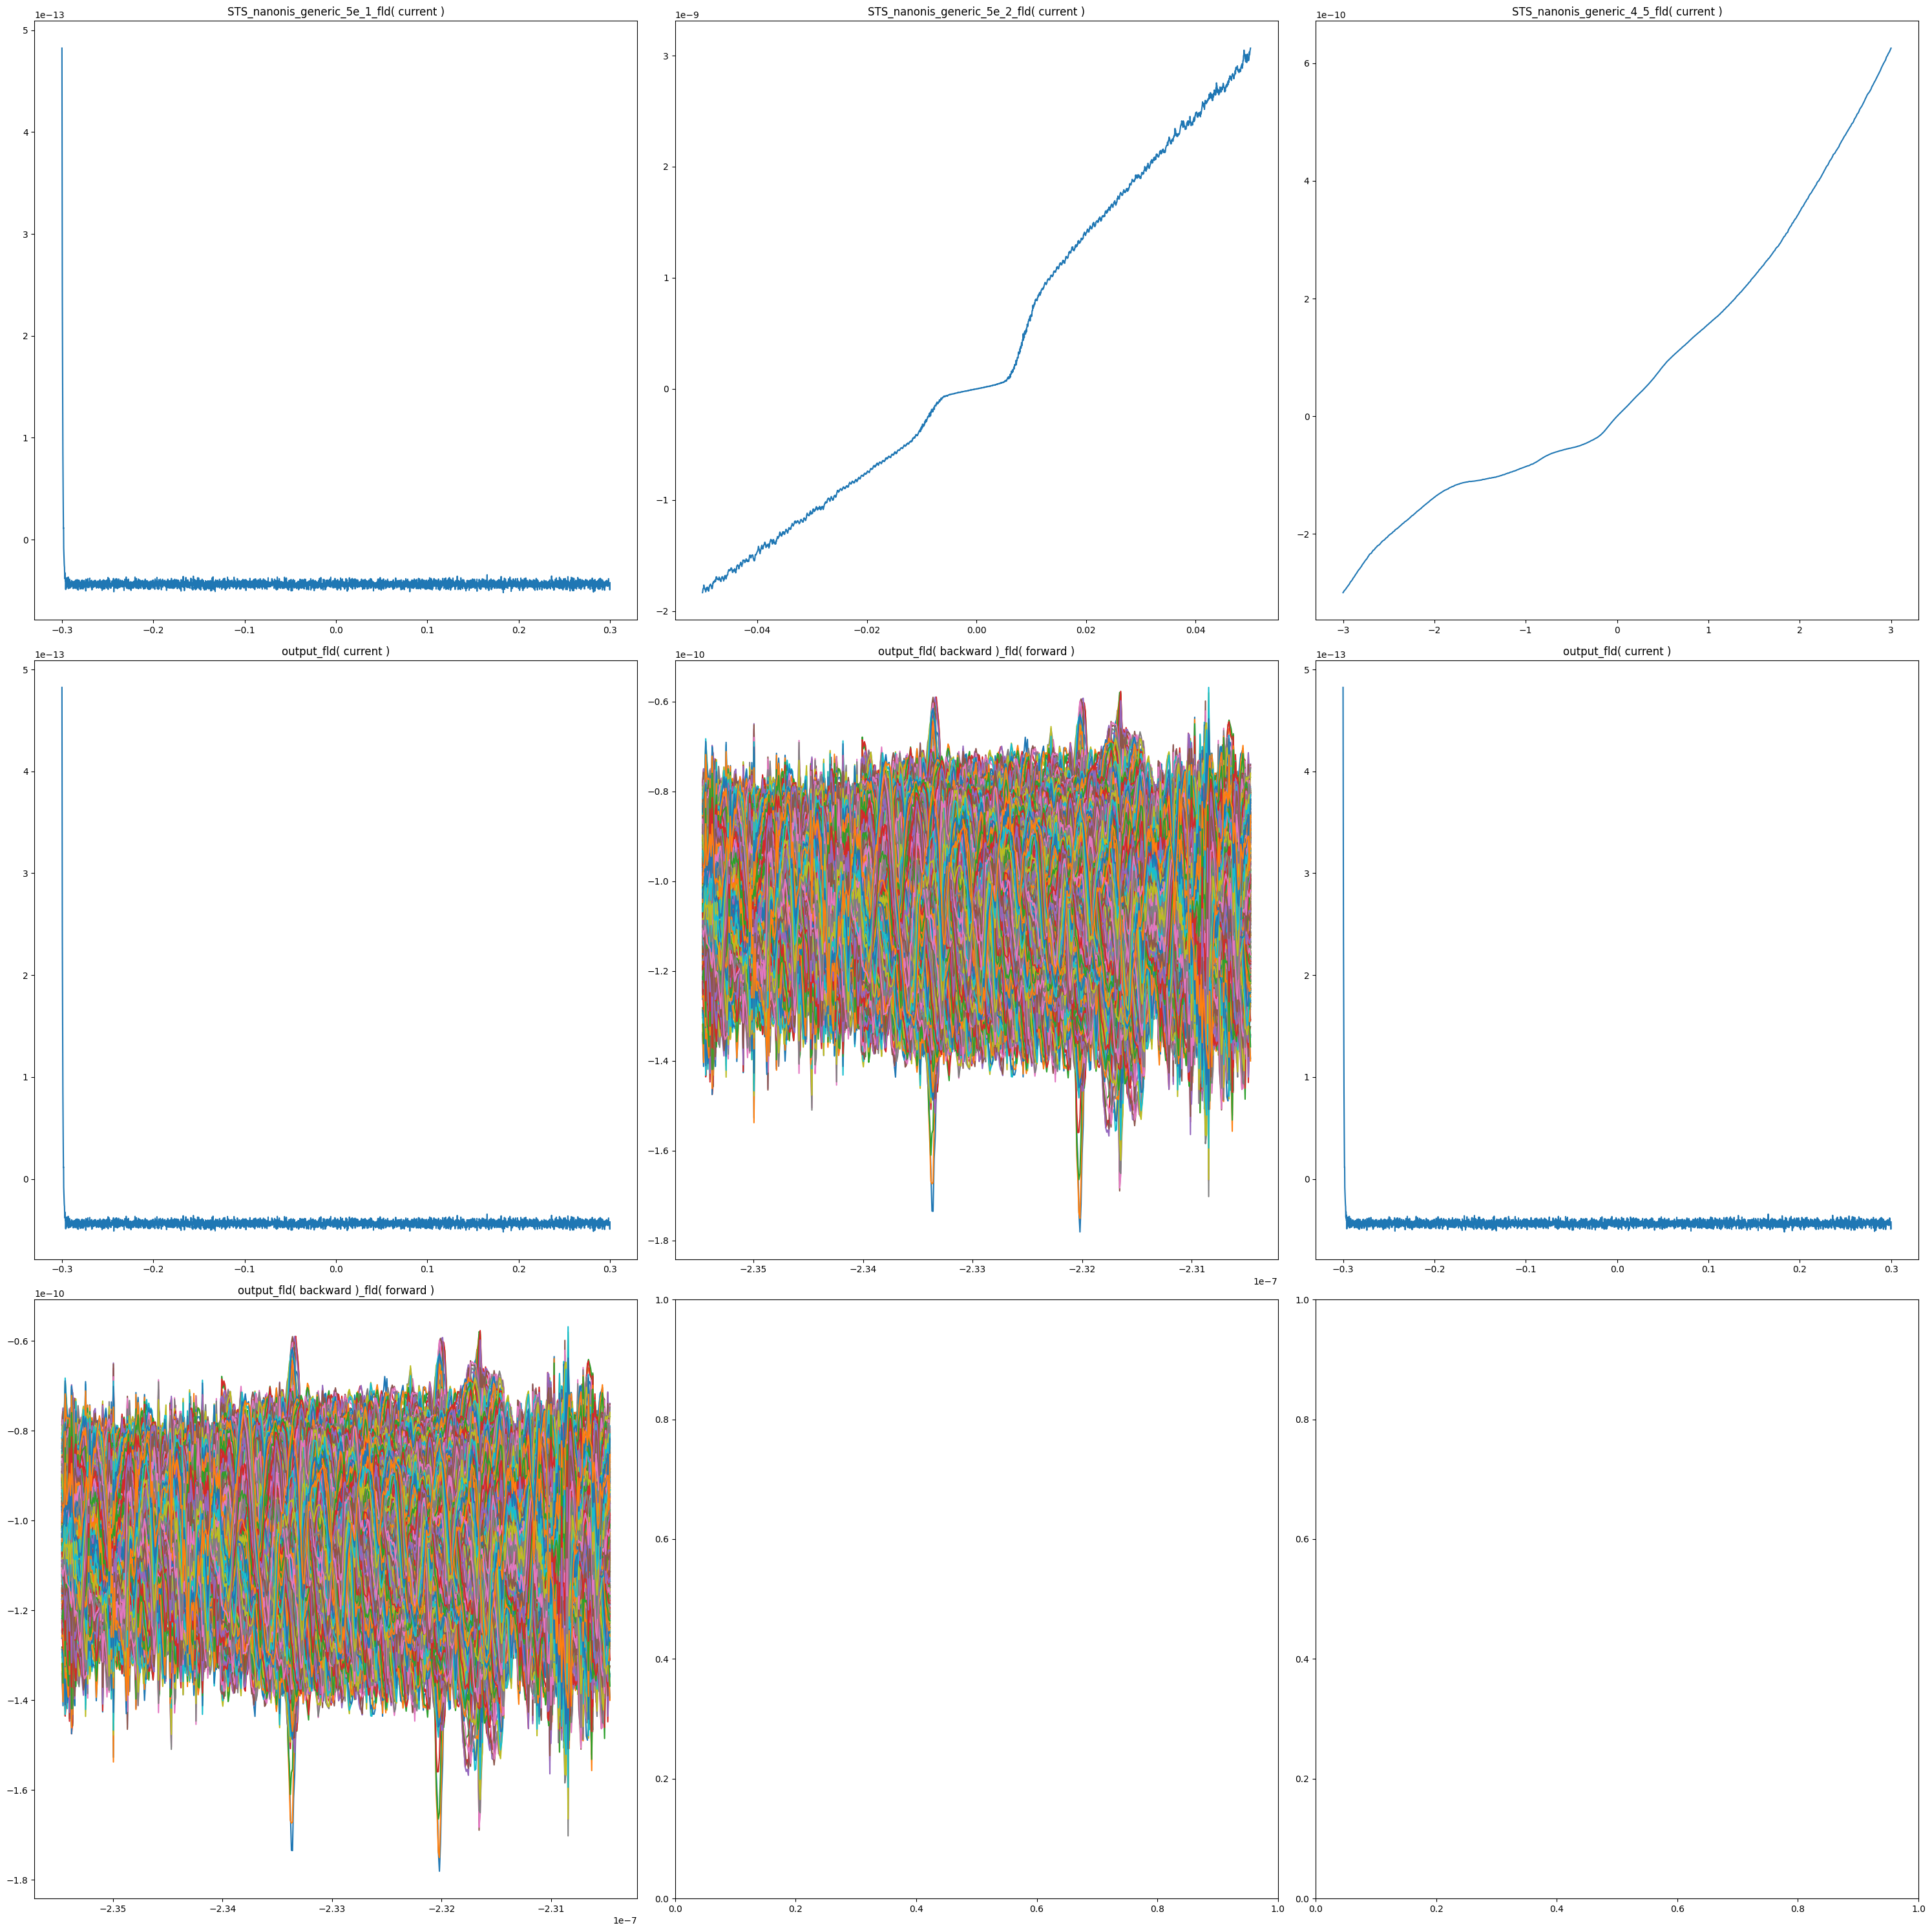

In [7]:
plot_li = []

# Collect all the `nxs` file from a directory
nxs_files = get_list_of_files(dir_='../', ext='nxs')
# Get
read_and_store_plot_data(nxs_files, plot_li, node_name='current')

# Plot all the collect NXdata group
plots(plot_li, figsize=(30,30))

# Run converter for a sigle file

## Example script to run STM reader

In [ ]:
# # STM to SXM file
# !dataconverter \
# --reader sts \
# --nxdl NXsts \
# --input-file STM_nanonis_generic_4_5__.sxm \
# --input-file config_file_for_sxm.json \
# --input-file eln_data.yaml \
# --output stm_output.nxs

## Example script to run STS reader

In [ ]:
# # STS or dat file
# !dataconverter \
# --reader sts \
# --nxdl NXsts \
# --input-file ./STS_nanonis_generic_5e_1.dat \
# --input-file ./config_file_for_dat.json \
# --input-file eln_data.yaml \
# --output sts_output.nxs

In [9]:
from pynxtools_stm import get_sts_raw_file_info
from pynxtools_stm import get_stm_raw_file_info

In [18]:
# Check how reader parse sts data file
# get_sts_raw_file_info(raw_file=os.path.abspath("../sts_example/STS_nanonis_generic_5e_1.dat"))

In [19]:
# Check how reader parse stm data file
get_stm_raw_file_info(raw_file="../stm_example/STM_nanonis_generic_5e.sxm")

INFO -  STM_nanonis_generic_5e.txt has been created to investigate raw data structure.
